<ipython-input-36-53cf5cfd03d0>:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data1 = pd.concat([data1, data.iloc[[x]]], ignore_index=True) # Append row as DataFrame


[[-0.12748903  3.          3.        ]
 [ 0.00614505  1.          1.        ]
 [-0.09461275  2.          2.        ]
 ...
 [-0.44427429  3.          0.        ]
 [-0.4158341   2.          1.        ]
 [-0.53476964  2.          0.        ]]
12034.308794145627
8310.198049720826
8256.765380015124
8244.81890888232
8241.656630339987
[1 0 1 ... 0 0 0]


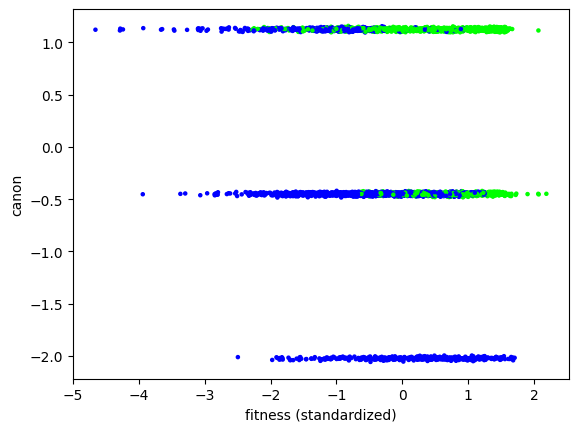

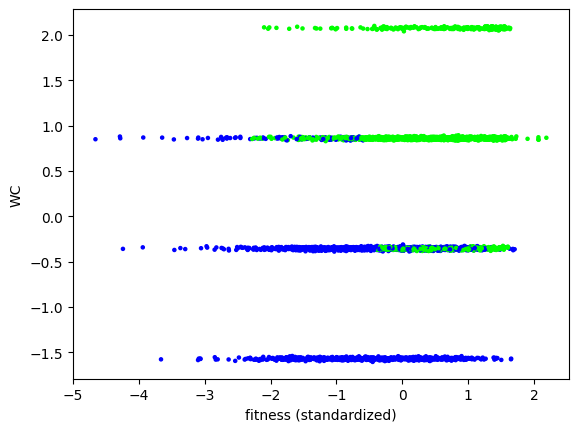

12070.86992208371
6506.480197993338
6372.672756648681
6326.6655978317685
6313.111540863752


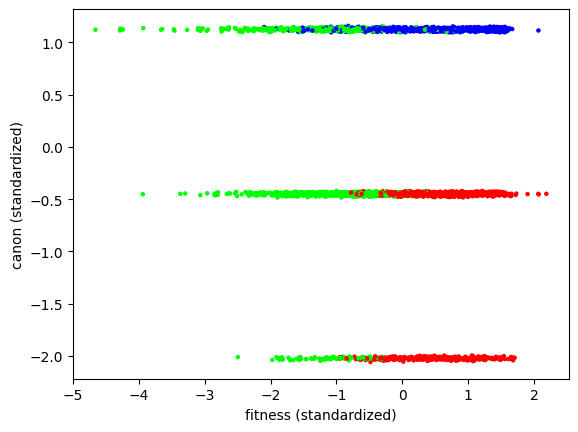

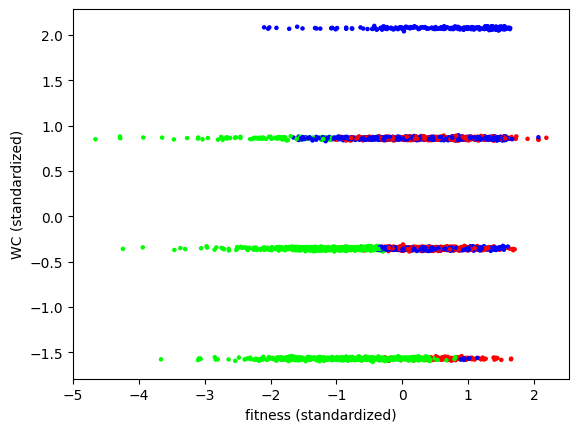

In [36]:
#Code strongly adapted from Roch MMIDS Section 1.3
#Dataset used is from Domingo et al. (Nature, 2020)

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import torch
import mmids

import matplotlib.pyplot as plt

data = pd.read_csv('rna_reads.csv')
num_rows = len(data)

canon = ['AU','UA','CG','GC','GU','UG']
WC = ['AU','UA','CG','GC']

for index, row in data.iterrows(): # Iterate through rows using iterrows()
  S_canon = 0
  S_WC = 0
  if row['stem1_71'] in canon:
    S_canon = S_canon + 1
  if row['stem2_70'] in canon:
    S_canon = S_canon + 1
  if row['stem3_69'] in canon:
    S_canon = S_canon + 1
  if row['stem1_71'] in WC:
    S_WC = S_WC + 1
  if row['stem2_70'] in WC:
    S_WC = S_WC + 1
  if row['stem3_69'] in WC:
    S_WC = S_WC + 1
  data.loc[index, 'S_canon'] = S_canon # Assign new values using .loc
  data.loc[index, 'S_WC'] = S_WC

columns_to_keep = ['fitness','reads_IN_1','reads_IN_2','stem1_71','stem2_70','stem3_69']
columns_to_keep = ['fitness','reads_IN_1','reads_IN_2']
columns_to_keep = ['fitness','S_canon','S_WC']



# Drop all columns except the ones you want to keep
data = data[columns_to_keep]
data = data.dropna()

#col = 0
#data = data.iloc[:,col] != -1.0

data1 = pd.DataFrame(columns=data.columns)
for x in range(1,num_rows):
  if data['fitness'][x] != -1.0:
    data1 = pd.concat([data1, data.iloc[[x]]], ignore_index=True) # Append row as DataFrame

# Now you can reset the index:
data1 = data1.reset_index(drop=True) # Reset the index after filtering




X = pd.DataFrame(data1).to_numpy()
#X = np.log(X)
print(X)

'''
plt.scatter(X[:,0], X[:,1], s=5, c='k')
plt.xlabel('fitness'), plt.ylabel('canon')
plt.show()

seed = 535
rng = np.random.default_rng(seed)
'''

def opt_reps(X, k, assign):
    (n, d) = X.shape
    reps = np.zeros((k, d))
    for i in range(k):
        #assign is a given array indicating which cluster element j is in.  assign[j] == i means j is in Ci.
        in_i = [j for j in range(n) if assign[j] == i]

        #optimal reps formula
        reps[i,:] = np.sum(X[in_i,:],axis=0) / len(in_i)
    return reps

def opt_clust(X, k, reps):
    (n, d) = X.shape
    dist = np.zeros(n)

    #starting state for assign is all 0s
    assign = np.zeros(n, dtype=int)
    for j in range(n):

        #need to compute the distance between every element in the ith cluster with the ith representative
        dist_to_i = np.array([LA.norm(X[j,:] - reps[i,:]) for i in range(k)])

        #this chooses the cluster Cj with minimal distance among the numbers computed in the previous step
        assign[j] = np.argmin(dist_to_i)
        dist[j] = dist_to_i[assign[j]]
    G = np.sum(dist ** 2)
    print(G)
    return assign

#assign outputs the optimal cluster cost given the reps in each iteration up to maxiter
def kmeans(rng, X, k, maxiter=5):
    (n, d) = X.shape
    assign = rng.integers(0,k,n)
    reps = np.zeros((k, d), dtype=int)
    for iter in range(maxiter):
        reps = opt_reps(X, k, assign)
        assign = opt_clust(X, k, reps)
    return assign


#Need to adapt the following to RNA.  But first need to remove the outlier point?


#X = data[['bill_length_mm', 'bill_depth_mm',
#        'flipper_length_mm', 'body_mass_g']].to_numpy()


'''
plt.scatter(X[:,0], X[:,1], s=5, c='k')
plt.xlabel('fitness'), plt.ylabel('canon')
plt.show()
'''
def spherical_gaussian(rng, d, n, mu, sig):
    return mu + sig * rng.normal(0,1,(n,d))



mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X = (X - mean) / std + spherical_gaussian(rng, X.shape[1],X.shape[0],0,0.01)

assign = kmeans(rng, X, 2)
print(assign)

plt.scatter(X[:,0], X[:,1], s=5, c=assign, cmap='brg')
plt.xlabel('fitness (standardized)'), plt.ylabel('canon')
plt.show()

plt.scatter(X[:,0], X[:,2], s=5, c=assign, cmap='brg')
plt.xlabel('fitness (standardized)'), plt.ylabel('WC')
plt.show()

assign = kmeans(rng, X, 3)

plt.scatter(X[:,0], X[:,1], s=5, c=assign, cmap='brg')
plt.xlabel('fitness (standardized)'), plt.ylabel('canon (standardized)')
plt.show()

plt.scatter(X[:,0], X[:,2], s=5, c=assign, cmap='brg')
plt.xlabel('fitness (standardized)'), plt.ylabel('WC (standardized)')
plt.show()